# Multimodal retail recommendation: using Gemini to recommend items based on images and image reasoning


Author :  Rahul Raj Pandey <br>rahul@econz.net

## Overview

For retail companies, recommendation systems improve customer experience and thus can increase sales.

This notebook shows how you can use the multimodal capabilities of Gemini 1.5 Pro model to rapidly create a multimodal recommendation system out-of-the-box.

## Scenario

The customer shows you their living room:

|Customer photo |
|:-----:|
|<img src="https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/rooms/spacejoy-c0JoR_-2x3E-unsplash.jpg" width="80%">  |

<!-- ![bg](https://i.pinimg.com/236x/2f/40/ee/2f40ee0162d2bab261ec76971e119aed.jpg) -->

Below are four chair options that the customer is trying to decide between:

|Chair 1| Chair 2 | Chair 3 | Chair 4 |
|:-----:|:----:|:-----:|:----:|
| <img src="https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/cesar-couto-OB2F6CsMva8-unsplash.jpg" width="80%">|<img src="https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/daniil-silantev-1P6AnKDw6S8-unsplash.jpg" width="80%">|<img src="https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/ruslan-bardash-4kTbAMRAHtQ-unsplash.jpg" width="80%">|<img src="https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/scopic-ltd-NLlWwR4d3qU-unsplash.jpg" width="80%">|


### Objectives

Our main objective is to create a recommendation system that can provide both recommendations and explanations using a multimodal model: Gemini 1.5 Pro.


## Getting Started [installation & colab]

### Install Vertex AI SDK for Python

In [ ]:
%pip install --upgrade --user google-cloud-aiplatform

### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).

In [ ]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

## Using Gemini 1.5 Pro model

The Gemini 1.5 Pro model `gemini-1.5-pro` is a multimodal model that supports adding image and video in text or chat prompts for a text response.

### Define Google Cloud project information and initialize Vertex AI

Initialize the Vertex AI SDK for Python for your project:

In [2]:
# Define project information
PROJECT_ID = "rahul-research-test"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries

In [3]:
from vertexai.generative_models import GenerativeModel, Image

### Load Gemini 1.5 Pro model

In [7]:
multimodal_model = GenerativeModel("gemini-1.5-pro")

### Define helper functions

In [4]:
import http.client
import io
import typing
import urllib.request

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


def display_image(image: Image, max_width: int = 600, max_height: int = 350) -> None:
    pil_image = typing.cast(PIL_Image.Image, image._pil_image)
    if pil_image.mode != "RGB":
        # Modes such as RGBA are not yet supported by all Jupyter environments
        pil_image = pil_image.convert("RGB")
    image_width, image_height = pil_image.size
    if max_width < image_width or max_height < image_height:
        # Resize to display a smaller notebook image
        pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
    display_image_compressed(pil_image)


def display_image_compressed(pil_image: PIL_Image.Image) -> None:
    image_io = io.BytesIO()
    pil_image.save(image_io, "jpeg", quality=80, optimize=True)
    image_bytes = image_io.getvalue()
    ipython_image = IPython.display.Image(image_bytes)
    IPython.display.display(ipython_image)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        print(response.headers["Content-Type"])
        # if response.headers["Content-Type"] not in ("image/png", "image/jpeg","image/jpg"):
        #     raise Exception("Image can only be in PNG or JPEG format")
        image_bytes = response.read()
    return image_bytes


def load_image_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)


def print_multimodal_prompt(contents: list):
    """
    Given contents that would be sent to Gemini,
    output the full multimodal prompt for ease of readability.
    """
    for content in contents:
        if isinstance(content, Image):
            display_image(content)
        else:
            print(content)

### Generating recommendations based on built-in knowledge

Using the same image, you can ask the model to recommend **a piece of furniture** that would fit in it alongside with the description of the room.

Note that the model can choose **any furniture** to recommend in this case, and can do so from its only built-in knowledge.

In [23]:
# urls for room images
room_image_url = "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/rooms/spacejoy-c0JoR_-2x3E-unsplash.jpg"

# load room images as Image Objects
room_image = load_image_from_url(room_image_url)

-------Prompt--------
Recommend a new piece of furniture for this room:


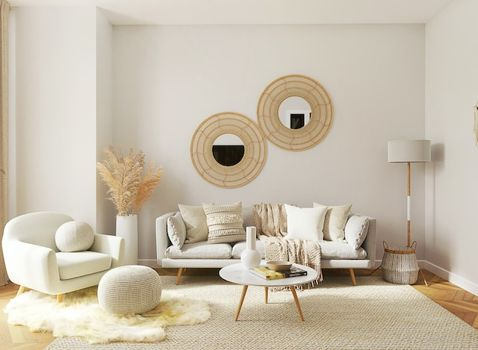

and explain the reason in detail

-------Response--------
This room would benefit from the addition of a **console table placed against the wall behind the sofa**. Here's why:

* **Visual Anchor:** The sofa currently appears somewhat "floating" in the space. A console table would ground it visually and provide a sense of structure to the room.
* **Functionality:** A console table offers a surface for placing lamps, decorative objects, books, or even a tray for drinks and snacks. This adds practicality to the space.
* **Style Continuity:** The room has a light and airy feel with natural textures. Choosing a console table with a similar aesthetic— perhaps one made of light wood or with a simple, minimalist design—would complement the existing furniture pieces and overall style.
* **Scale and Proportion:** The wall behind the sofa is fairly large and empty. A console table, especially one that is roughly two-thirds the length of the sofa, would fill the space proportionally without overwh

In [24]:
prompt1 = "Recommend a new piece of furniture for this room:"
prompt2 = "and explain the reason in detail"
contents = [prompt1, room_image, prompt2]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

-------Prompt--------
Describe this room:


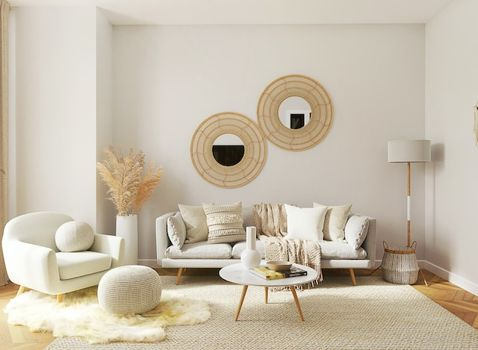

and recommend a type of chair that would fit in it

-------Response--------
This room exudes a light and airy ambiance, characterized by a neutral color palette and natural textures. It features:

* **Walls:** Painted in a soft, off-white hue, creating a calming backdrop.
* **Flooring:**  Light wood floors in a herringbone pattern add a touch of elegance and warmth.
* **Furniture:**
    * A contemporary off-white armchair with rounded edges offers a cozy seating option.
    * A matching ottoman provides a place to rest feet or serve as extra seating.
    * The centerpiece is a light-colored sofa adorned with plush pillows in white and cream, accented with subtle patterns. 
    * A round coffee table with wooden legs sits on a natural fiber rug, completing the seating area.
* **Decor:**
    * Two circular rattan mirrors with different diameters grace the wall, adding visual interest and reflecting light. 
    * A tall, slender floor lamp with a white shade and wooden base provides soft 

In [18]:
prompt1 = "Describe this room:"
prompt2 = "and recommend a type of chair that would fit in it"
contents = [prompt1, room_image, prompt2]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

### Generating recommendations based on provided images

Instead of keeping the recommendation open, you can also provide a list of items for the model to choose from. Here you will download a few chair images and set them as options for the Gemini model to recommend from.

image/jpeg
image/jpeg
image/jpeg
image/jpeg
-------Prompt--------
Consider the following chairs:
chair 1:


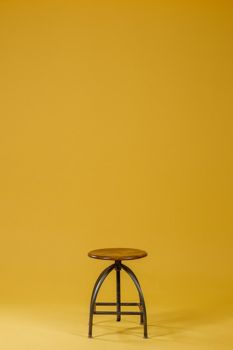

chair 2:


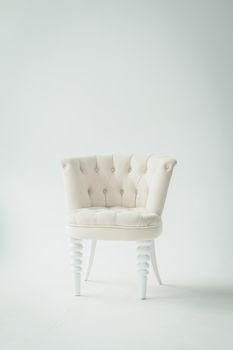

chair 3:


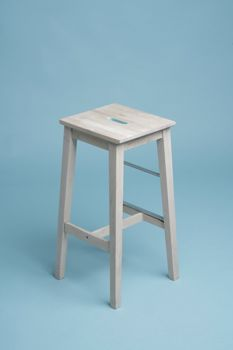

chair 4:


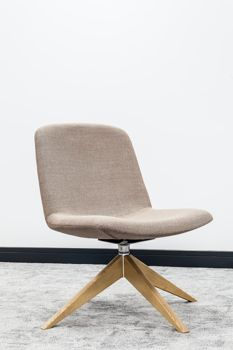

room:


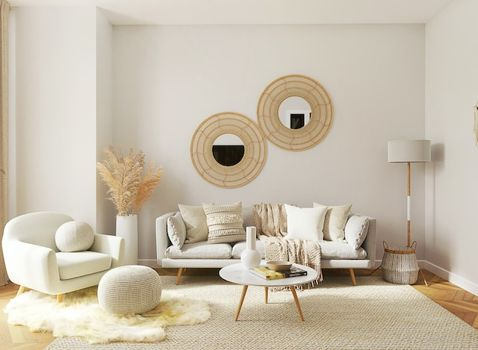

You are an interior designer. For each chair, explain whether it would be appropriate for the style of the room:

-------Response--------
Here's a breakdown of each chair and its suitability for the room:

**Room Style:** The room has a warm, minimalist, and slightly bohemian feel. Think natural textures, neutral colors, and simple shapes with a touch of cozy.

**Chair 1 (Industrial Stool):**  This chair is **not a good fit**. Its industrial aesthetic clashes with the room's softer, more organic vibe. The dark metal and utilitarian design would feel out of place.

**Chair 2 (Tufted White Chair):** This chair is also **not a good fit**. While the white color works well, the chair's traditional design and tufted upholstery are too formal and ornate for the casual elegance of the room. 

**Chair 3 (Wooden Bar Stool):** This chair is a **possible fit, but not ideal**.  It leans more modern and minimalist, which aligns somewhat with the room. However, its function as a bar stool makes it be

In [38]:
# Download and display sample chairs
furniture_image_urls = [
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/cesar-couto-OB2F6CsMva8-unsplash.jpg",
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/daniil-silantev-1P6AnKDw6S8-unsplash.jpg",
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/ruslan-bardash-4kTbAMRAHtQ-unsplash.jpg",
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/scopic-ltd-NLlWwR4d3qU-unsplash.jpg",
]

# Load furniture images as Image Objects
furniture_images = [load_image_from_url(url) for url in furniture_image_urls]

# To recommend an item from a selection, you will need to label the item number within the prompt.
# Labelling images within your prompt also help to reduce hallucinations and overall produce better results.
contents = [
    "Consider the following chairs:",
    "chair 1:",
    furniture_images[0],
    "chair 2:",
    furniture_images[1],
    "chair 3:",
    furniture_images[2],
    "chair 4:",
    furniture_images[3],
    "room:",
    room_image,
    "You are an interior designer. For each chair, explain whether it would be appropriate for the style of the room:",
]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

#### Chair Fit Assessment:

| Chair | Fit? | Explanation |
|---|---|---|
| Chair 1: Industrial Stool | No | While the wood tones are somewhat compatible, the industrial style of the stool clashes with the soft, natural aesthetic of the room.  |
| Chair 2: Tufted White Chair | No | The ornate, traditional style of this chair feels out of place in the modern, minimalist setting. The white upholstery also doesn't complement the existing color palette. | 
| Chair 3: Light Wood Stool | No | This stool's minimalist design and light wood tone could work as an extra seating option. However, it might feel a bit basic and lack the comfort factor of other pieces in the room. |
| Chair 4: Modern Swivel Chair | Yes | This chair is a great fit! Its clean lines, comfortable upholstery, and wood accents blend seamlessly with the existing furniture and overall design style. | 


## Test 

### test1


You can also return the responses in JSON format, to make it easier to plug recommendations into a recommendation system:

In [45]:
contents = [
    "Consider the following chairs:",
    "chair 1:",
    furniture_images[0],
    "chair 2:",
    furniture_images[1],
    "chair 3:",
    furniture_images[2],
    "chair 4:",
    furniture_images[3],
    "room:",
    room_image,
    "You are an interior designer. Return in json format, for each chair, whether it would fit in the room, with an explanation:",
]

responses = multimodal_model.generate_content(contents, stream=True)


print("\n-------Response--------")
for response in responses:
    print(response.text, end="")


-------Response--------
{
  "chair1": {
    "fit": false,
    "explanation": "This industrial-style stool would look out of place with the soft, neutral tones and natural textures in the room."
  },
  "chair2": {
    "fit": false,
    "explanation": "While this chair has some elegance, its ornate style clashes with the modern, minimalist aesthetic of the room."
  },
  "chair3": {
    "fit": false,
    "explanation": "This simple stool lacks the visual interest and comfort level needed to complement the room's design."
  },
  "chair4": {
    "fit": true,
    "explanation": "This chair's mid-century modern design, neutral color, and wooden legs would blend well with the existing furniture and overall aesthetic."
  }
}


In [49]:
from IPython.display import display_markdown

contents = [
    "Consider the following chairs:",
    "chair 1:",
    furniture_images[0],
    "chair 2:",
    furniture_images[1],
    "chair 3:",
    furniture_images[2],
    "chair 4:",
    furniture_images[3],
    "room:",
    room_image,
    "You are an interior designer. Return in tabular format, for each chair, whether it would fit in the room, with an explanation:",
]

responses = multimodal_model.generate_content(contents)

display_markdown(responses.text, raw=True)

## Chair Fit Assessment:

| Chair | Fit? | Explanation |
|---|---|---|
| Chair 1: Industrial Stool | No | While the wood tones are somewhat compatible, the industrial style of the stool clashes with the soft, natural aesthetic of the room.  |
| Chair 2: Tufted White Chair | No | The ornate, traditional style of this chair feels out of place in the modern, minimalist setting. The white upholstery also doesn't complement the existing color palette. | 
| Chair 3: Light Wood Stool | Maybe | This stool's minimalist design and light wood tone could work as an extra seating option. However, it might feel a bit basic and lack the comfort factor of other pieces in the room. |
| Chair 4: Modern Swivel Chair | Yes | This chair is a great fit! Its clean lines, comfortable upholstery, and wood accents blend seamlessly with the existing furniture and overall design style. | 


### test2

image/jpeg
image/jpg
image/jpeg
image/jpeg
image/jpeg
-------Prompt--------
Consider the following swatch boards:
switch board 1:


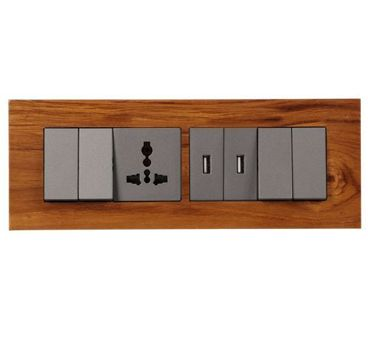

switch board 2:


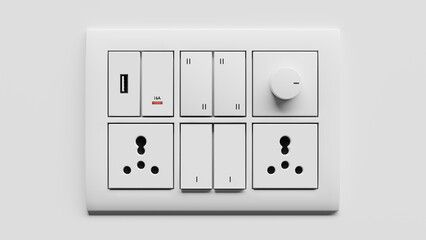

switch board 3:


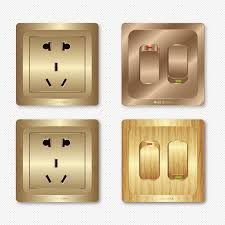

switch board 4:


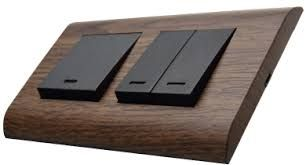

room:


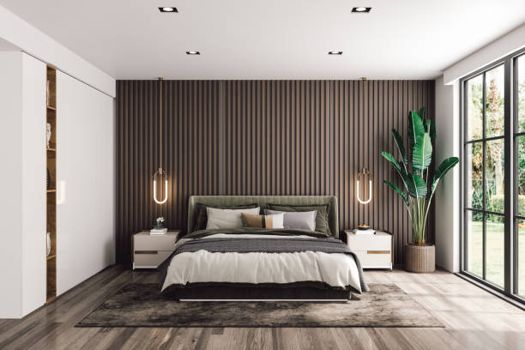

You are an interior designer. For each swatch board , explain whether it would be appropriate for the style of the room in brief with a rating, also give assesment in tabular form:


Here's an assessment of each switch board's suitability for the bedroom:

**Overall Style:** The bedroom features a modern, minimalist aesthetic with a warm and natural feel. The wood paneling, neutral color palette, and simple furnishings all contribute to this style. 

**Switch Board Assessments**

| Switch Board | Appropriate? | Rating (out of 5) | Explanation |
|---|---|---|---|
| 1 | Somewhat | 3/5 | The wood finish aligns with the room's natural elements. However, the design feels a bit bulky and the gray color clashes slightly with the warmer tones.  | 
| 2 | Not Really | 2/5 | This switch board is too stark and utilitarian for the space. The bright white finish and simple design don't complement the room's warmth or sophistication.  | 
| 3 | Depends | 2.5/5 (Gold) 4/5 (Wood) | The gold finish feels too opulent and clashes with the room's modern, understated elegance. However, the wood finish option could work well if it complements the existing wood tones in the room.  |
| 4 | Yes | 4.5/5 |  The sleek, dark wood finish and minimalist design of this switchboard align perfectly with the room's modern, warm aesthetic. The curved edge adds a touch of unique character. |

**Recommendation:** Switchboard 4 is the best fit for this room, followed closely by the wood option in switchboard 3 if the wood tones match. 


In [19]:
from IPython.display import display_markdown
# urls for room images
room_image_url = "https://media.istockphoto.com/id/1390233984/photo/modern-luxury-bedroom.jpg?s=612x612&w=0&k=20&c=po91poqYoQTbHUpO1LD1HcxCFZVpRG-loAMWZT7YRe4="

# "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/rooms/spacejoy-c0JoR_-2x3E-unsplash.jpg"

# load room images as Image Objects
room_image = load_image_from_url(room_image_url)



# Download and display sample chairs
furniture_image_urls = [
    "https://img.staticmb.com/mbcontent/images/crop/uploads/2023/3/Wooden-modular-switchboard-designs-with-switches-and-sockets_0_1200.jpg",
   "https://t3.ftcdn.net/jpg/06/25/01/76/240_F_625017618_XEaENhgwNaQibpH5yzlqFvVNuyq1jBNE.jpg",
    "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxISERUSExIVFhUXGB0XFhcVGBcYFRgVGB4XGxgXFxcYHSggGBolHRoVITEhJSkrLi4uGB8zOTMsNygtLisBCgoKDg0OGhAQGi0lHR8wLS0uLS0tNy0tLS0tLS0tLS0tLSsrLS0tLS0tLS0tLS0tKy0tLS0tLS0tLS0tLS0tLf/AABEIAOEA4QMBIgACEQEDEQH/xAAbAAABBQEBAAAAAAAAAAAAAAAAAQQFBgcCA//EAEgQAAECAwIJBwcJCAIDAAAAAAEAAgMR8AQhBQYSMWGhscHRIkFRcXKBkQcTFCMyUpIzNEJTYoKy0uEVJFRzorPC4kOTFmPx/8QAGQEBAAMBAQAAAAAAAAAAAAAAAAECBAMF/8QAKxEAAgECBQMEAgIDAAAAAAAAAAECAxETFCEyUQQSMTNhcfBBgSJSI8HR/9oADAMBAAIRAxEAPwDaEVVcUVVb0VVakAIRVVuRVVrkgCqrXchFVWtFVW9ACKquKKqtU0VVakAIRVVuRVVrkgCqrXchFVWtFVW9ACKquKKqtU0VVakAIRVVuRVVrkgCqrXchFVWtFVW9ACKquKKqtU0VVakAIRVVuRVVrkgCqrXchFVWtFVKtaAEVVcUVVapoqq1IAQiqrciqrXJAE6meCEV9JCAEVVadCEVVa7kA0j4UgMcWvjwmuGdrntDh1gm5cjC9n+vhfGzisagPLuUTMm8k5yTeSe9SMBwCyZl8GjAXJqwwnAP/ND+NvGta7FuhH/AJGfEOKzaBaWDO6Xc7gpCBhKCM7/AOl/BRmXwRgl8FpYfpDxC686OmqrmVRgYes4zvPwv4J2cZrLKWWfgfwTMvgjCLAbUwZ3tHeFwcIQRnis+JvFVK0YcgHM8/C7goy0W+GcztTuCZl8E4RfThazjPHhfG3jWtcHDdl/iYP/AGM4rM7RFacx1Hgou0pmXwTgrk21jw4Aggg5iLwQegjOuqquCp3k4jE2fJJuDnAaBOcvFXGqrXctcXdJnCSs7Am9pt0KGQHxGNJzBzgD4EpwqFhSEXWmKT70u4SAHgFSpPtVy1OHc7FybhKCc0Vh+8ONa16elw/fb4hUiLbIMADzrwCcwvLj3C+WlN34wwHZnn4X8Fxx3wdsBF+NvhDPEZ8Q4rg4TgfXQ/jbxrUs9famuzOHg7gm77I92aWvgmO+BgLk0g4Xs/18L42cVwcN2X+Jg/8AYzisziYAtDrwG/EmMTF6Pz5HxfomO+BgLk1r9uWX+Jg/9jONa0v7bs38RB/7GcVkH7IeM5b4/ovRlnDc5GvgmYfAwFya5+2LP9fC+NvFOYFoY8TY9rh0tII1VsWbYKsofeJEaFZsEnIihrecGemREvCZVoVnKVrFZ0klctCEBC0HAJVI8UqSVSHFCAKqtckhqq8UqQ1Vb0BhtibPJHTIeMlLR25IEhOZkBm5idgUZgsTczrbtCsNtgex2/8AF68s3Mjg487df6LqY6Cnno6q+NWNQsUVkIQfOOLQ903FoDSSABIGZ5JvzC7PzTFOTsiG7E5lDoKTK0FMsUbY+02YRnyynOdcAAAA5wAuA5gE6w890GzxYrZBzGOcJiYmASJg575J262F9LneVoSF32daruLmOYtdobAdAyC5pk5r8oZTWlzspuSJAydKWYyGkW/0dJRcXZhNMZQ3EuALZTzXzzdybYThyI0hSzIHLb37EyxgZIt6ioJLV5NvkT2juqgrtVVrVJ8m3yJ7R3K7VVaNK9GntRkqbmFVW9VSPBHnYjj7x2q1qo4Tjye8faO0rnX2ovR8mdWkuixXvdnLj3DmHUBIJ9ZLGveyWSalIbGsLWm9zvZHOZZzoAmL9KymoSx2LQpiDZw0TKj4WHbM0ua54a5ozOkAeomU/BcHCmWJykCSBfzgT0cwKi4cZJJteR9abUoq02peNptKjxGDje6Q6ZE+ACEHVotKi7RaU5tUEfRiT62lvFR74JBv8UJJfFS1ubGInc5pmNIvB2jvV0wNEnHHUdoVFwK3Jig6DsKuGLL5x+7eF0pb0c6u1l7FUK1oqq1TQELcYwr6KETqY4IQAkNVXhelqq3pDVV4IDE8CicSF2m7QrlbIF8Pt/4RFUMXxONBH22bQtDtdn5ULtn+3FXlm2T1Iz0ZNbZgSDGLTFgw4hbe3LY10uqYzaFY/RUeiqCtyr4HwBDszDDh5WTlF3KIMibzKQF0164SwQ2PCdCfPJcJOkZGXPfzKftDGsaXvIa1om5xuAAzknmCSzBkRjYkNwexwm1zTNpHSCM4U6+Rcr1iwBZ4JyoUCGx2SGlzWNDyBLO4C+cgT0lPPRlM+jI9GUO7FyD9H9Yz72xQ2NsORZ1HcrfEs/rIf3tirWPbJGF1O2tUkp6kv5NvkT2juV2qq1Xqk+Tb5E9o7qoq7VVal6NPajNU3MFQMORpRog+0Vf6qtyzHGWLK0RR9ornX2ovQ8khg6x8kHQFD4yWswbSxzACRDunmmXOvuU6LTJjQPdGwKuYTb5yN1MH4nrKaSKZbnhznBjJuEjMOPhN1y6bbnFoY5oDQS4SnOZBHOc16eixaFxaLJJjj0AlQWuNrbarj1FStmsPIbd9EbAqvHcSD1FaRYms82y/6DdgUkMgvQdCYW2y+sA+yDrPBXLzbOlR0eyB8fk3gMb+J6gghYdnyQHadxU5ig6cc9W9cYbY1kEAZ8obCkxKPr3dW9dKW9FKm1mjBCKqtyKqtcluMYTqZ4IRX0kIASGqrp0JUhqq8bkBjOLXziB/MZtC1C2FuVB/mH+3FWWYAMo0E/bZtCv9utN8Ltn+3EXlmya1JzLajLaoX0teNrwtDhML4sRrGDO55AA5s50yHeoKWHWNnKsNpa0EuMJwAAmSSLgAM5TbEGGWYNsrIjS17YTQ5rgQ4EcxBvBXr6XpS+lqb6WFiZymoymqAsuFYcQZUN7XgEtJaQRlNMiLucFe3pelQLEjGLTEh/e2Ko+UcDKgy9121qmfSvWQ/vbFXse4mUYXU7a1SWitSX8m3yJ7R3K7VVadCpPk2+RPaO5XaqrXcvRp7UZ6m5gsjxtiytcYfbO5a4sXxxd++xx9vcFzr7UdKG4lXWnkt6hsXOBmecjRNDGbYiiIlpuHUE/xTtUosY/ZZtiLKaCxDB+hN8KWGUCIehjjqKd+mpphO1TgxB0scNSgFIEHknqKnbPhGTGif0RsXECwktN3Mdig2GfsuEuYOIBl33HuUklk/aWlO8FW2b4h+ywa4nFVIh3SPiCk8CxZB98zdM83PKWtQCUwzHm3v4p1iMfXu6htUNbHzAGnip3Elkox6t66Ut6OdTYzRUICFuMYS0ajxQiWjUOKEAVVa5JDVV4pUhqq6NKAxPA5lEhn7TdoVrt9o+T7f+D1T8HukWnoIPhJT1pcXASImDO/NmI3ryjcx96Um+EYcOPCfBiibHgtd03840gyI0gJoA7R4nguu7+r/RCLHnixEtEOziFaByoZMNr5g+chtuY+U5iY6b7p869cPWm0GC5lmaDFfyGuLg0Qw64xCSfogk3TPPzJO7+r/RF9O/1U31uRbSx74Js8OzQWQIXsMEgedxzucdJJJ7079KUbfTv9Ukjo+L/VQ9dSbEnDtPrGfe2KMxriTLOo7ksEEODiRdPNPnTLDcXKI0DagS1Ld5NvkT2juqgrtVVrVJ8m3yJ7R3K7VVaNK9KntRlqbmFVW9YzjY2duj9vcFsyyLGWFO2x+3uC519qOlDcyvOeSnFgjOhuym9RHSFw2AZyUhZbJNZTSSEK35Q+TdPpyxLwyN6eWWA9+demD8GzUo57WCQ8VBAkKE2GNKrlowLByy4FzROeS0gAdUwZBSdptKjY0dAeFvs4eJZb5TnfknY0LyaAxuS0SG09JSxIi8HOURioqyQSS8HpDvcBWYq1Yqw5Ru7eFWsFwS6INEzuVvwHDlFb1Ha1daW9FKu1lyFVW1FVWqaAhbjGFfRQidTHBCAEhqq8L0tVW9FVWpAYZZhK45wpOzrRLbizZ4jy8w2zN5Iumek6aK824qwRmaNaxvppcmnGRT4EBpzjWU+g4NhnmPirM3FyGMw21XSvRuA2jMVGWlyRiohIeAIJzl3c4cF7PxdgAT9b4jm7lMtwYRmeV6egv+sOqq6Ey0uSuKVV+B4XN5zvP6JjHsTBmn4q5vwVPO4rydgBhzplpck4qKBHEsyibUtQdixCOcbarpXmcULOc7BrU5aXJbGRG+TcepPadw4q61Var0zwdg9kFoa0ADmAzaq7pp5VVqWqKskjPJ3dwWa4Zs07XGP29wWlVVblHW7BMOI7KI5XSJg9/T3qtWDmrIvTn2sprMDw3DKeCD0i4pBAhw8wn1/orYcCD3j4mq6VycAM0eC4ZeR1xolVi4UIEg1v9XFN3R3uAd6u+d2UZiXSJq3nFuEeYeAXBxXg+63wFV0Jl5DGRRoz3dDM5Gd3Nd0prFefdb3E8VoRxUge43wqu5J/4pA9xvgmXlyMaJn0OHPOBr4p5Bwe08x8VeBizCGZo8KrSvRuL7BmTAkTjorlgsQbcApPBzwY4aL8kGfeRwKk/wBiD3j3HgvbB+CWQjMV3mu5XhRcZXZSdVNWJJCKqtyKqtcloOAT06zwQivpIQAiqrToQuXmQJqqz3IDxi22E05LojAeguaD4EpBb4X1rPiHFY5AeXHKJm43knOSbyetSNncOdY80+DRge5qgtcP32+I41rXXpLPeHis8gRmDO4KQg2+EM7260zL4K4RdPPN6Ql84OmqrmVagYYs4/5B4O4J27D9myflR4O4Kcy+CMMmTHb7w8Vz6VD99viFWLRheAc0QeDuCjLRbIZzPGtMy+CcIvBt0L6xnxDjWtcnCUH66H8beKzW0PaecFRNqUZp8FlRXJtDHg3gz6l1VVp0Kk+Tq0uMMsJmATLQLjJXaqrXctUZdyTOElZ2BecWO1vtODesgbV6LPMORC61RpmcnBo0AASA6AuVethRvY6Uqfe7F79OhfWM+Ica1pfS4fvt8Qs6s5GS7rO+9SMGIJBsxOSyZ9/1Oz6ZL8l19KZ77fELoR2+8KqsyqcO0MlLKE09s2EYWSOWLjp4KV1z4KOgWDzo6Unnm9IUXDwtAvHnB4O4Jq/CcEzPnBLqPBWzvsQqLJw2lnvN8arxSemQ/fb4hVaPamSllCd/SmMR7b2zEyDrFypn3/Uuun9y7enQvrGfEF6QozXCbXAjpBBHjW5Zm1vJN3/2Uk7xPtDmRckG482kc660er75qLQn0/bFyv4NFQgIW0yhKpHihEtGocUIAqq1yXEX2T1VW9drmL7J6qru0oDEbEyeSOoeMgpeOMkDk5zIDuJ2AqNwZ7TOtu0KwW2B7Hb/AMHrykbpEc0n3R4nc1d5PZ8XflTz0dVfGrGuHYorIRgGK4ty3cvIAaSQB7JmTJ3RK7PO60YuTsirdibl2fF35US7Pi78qZYpW51qs4jPABc51zcwAc4AdcgL06w9FMGzRYrQMpjHOGUJiYBIn3hO13sL6XOyOz4u/KkloHi78qruLuOkO12hsAwDDLmnJcH5QLmtynAtyRkggOIvPMOeYt/mElFx0YTuMWGZALZTnfOeZNMJwpHrCl2Wflsu6diZ4fZIt6iqlk9Sf8mw5Lu0d1UFfaqtaoXk49l3aO5X2qrRpXo0tiMlTcwqq3rOMM/Oov8AMGxq0dZzhd371G/mDY1Zuu2L5O/S7n8CwoXq585BcesyXp5rlCXup1Ah+rafsjXJcWqM2G5uVnIIAGc5p9w4dIXlmm55MhcormyweSe0NoTqzeblMxYbSRmc4NPXypLqFyXZDhIzzzBGjMVNg7obCF7XaXiyF6vX4SUl5vP2ktjsrntuFxuDj7J0jnI0yv5lFrkd1iOiQ756TvQIXrO7ZMKUjWF4lIZXVd09PWmphEPIkQQMxzo1YlSuR9phSJOncTuXOK/y7e/anuE2SB7W5yY4qmcZvetHS+qvvJWo/wDEzShVCtaWqrVNIEq9k84K+ihE6mOCEALiJ7J6qrdeu6qt64i+yeqq3IDGcDH1kIdLmbQrhbIF8Ptn8ERVPADZxoPbZtC0C2WflQu2f7cVeXE2zepG+jphhHF6z2gtdGgMiFvs5QzaLs40GYVn9FR6MpWhS5VcA4vMskPzUMuLcou5UpjKMyBIC7uXthbA7bRBdBeSGvEiWyDpHoJBCsMWG1jS5xDWi8k3ADpJ5gkgMa9ocxzXNN4c0gtI6QRnTW9xcrGDsWLNAdlwoDGPyQ3LAGUQJDqBMr5ATUl5hTHoyX0ZHdi5BGz+sZ97YofGxsizqO0K2xbP6yH97Yq5jzDkYfU7aFD8FovUe+Tc8l3aO5X2qrVeqH5OMzu0d1UVfKqtS9ClsRmqbmCzjDB/e438wbGLR6qtyznC4/e43bGxp3LN13pr5O/S7n8E1ZoPqmdkbkxj4KMa2tE5NZBBPTNznAAdctSnrJA9UzsjcvCG7ItbtMFn44q8+MTp3cHcPA0IAEwmOObltDrui/rTLGHBp81Eii4tbPuHR0EZ+5S5tfJTPDVonZ4w/wDW7YUsnZDul+TytMOTHnMZE6lIYLe3zEG7/jZ+ELm1wuTE6nbFGWC0+pg9hv4Qp2ojcThe2WZRFtvtRlm80zW+KunWmQcvOxHKtDtEKH+KMq3vp98hK2ozw0yTCftD8LlE4qn1zVPYzQpQTpcB4hw3qDxaH7x3ldum0qr9/wCy8n/iZpASpBVVsS1Va5L2DzxZ6dZ4ISV9JCAFzFzHqqu/QulzFzHqqt9yAx7Fsjz8D+ZD/EFp1sycuD/MP9uKstwBdGg6Hs2haBbrTfC/mH+3FXlxNk1qTWU1GU1Q/pWlecfCLIbS572taBMucQABpJUnOx643yNhtIAJJgvAAvJMswTXyfMycGWRrwWuEFoIIkQegg5inXpSPStKm+lhYl5tRNqhIGEmPE2Pa4TIm0gibSQRdzggjuXp6UoFh/GyfOQ/vbFUvKLIOhdl21qmjafWQ/vbFXce4mUYegO2tUPwWgtR75N8zu0dyvtVWnQqF5NxyXdo7lfaqtdy9ClsRwqbmCzrCnzuP2/8QtFWeYS+dRh9vcFm6/018nfpdz+C52IDzTOy3YFCYWi5NrEueC38URSNji+qb2RsCr2MMfJtTSfqR+J/FYW/4l4R/ke5tXJHduXjbrROHFE/okalFG1ckju1riNaZteOlp3rinqd+w0W1gZD+p2wqlWKP6mDf9Fv4QrVaYvIf2XbFndhtoMJl4Eg3OQMwHSV0nqjnSj5J42mYdPr1cVI4tOBjRT/AOuHtjKsxbSJO5Tc3vN6OtSuKNpnEjGd2Swa4h3qkfNy84/xZN41NHmR226so7lWcWvnH3juVhxiiThjtDY5V7Fk/vAGk7VpoesvvJyfos0gJUgSr1zCEql+qESqQ4oQBVVrkuYvsnqqt66XMXMeqq7tKAxnA5k+GftN2hWu32j5Pt/4RFTcHukWnoySeoSU/a3FwbKVxnfmzOGfvXlI3SWpI+kpnhezw7TBfAiibHgg9IPM4T5wZEdSatDucjuJ4L0yT72pTdlbHjiraLQ2zth2hpESGTDy+aIxlzYgvnIiV5zynzr2xgttoEBzbMwvjP5DCJSZlcnzh0NBn3TNwKTJ+1qRknpU31uRbQ9MB2OHZYDIEO8MF7ud7jMueeszOgSHMpD0pReSelGSekKG2ybIkmWn1jPvbFGY1xJlnUdoRCDsoOMpCeYk5+65MsORcojQNp/RGSlqWTycZndo7qoK+VVa1QvJt7Lu0dyvtVWjSvQpbEZam5hVVvWe4T+eRe1uC0JZ9hP53F0P/wAQsvX+mvn/AKd+l3P4JmyRfVDsjYE1wtYWxgwkkObORHQc4PSLlxZIvquoS8LiPFejovsrzrna1mRz8XWyI846Zv5pbF64MwE1r8t7i6RuHNOc5m7p5k9tMTMV1Bi5+sqb6lu6VvI8EW49arpxZhF02uLWh1zQBdoE+ZS7Yl561yIvtaDWxLlVdeCKtWAMpsvOEg9IaNgvUrg6xMgNa1vP7TjnJ5ppIkTkjq4IixJFormVUklZBLSxxht3JA+0NhUTi184b1T8ZqQwlEnId/cAeITHF35wOuS79N6y+8ifpM0YVVbUtVWqaQJV7J54V9FCJ1P9EIAXMTMeqq3XrqqrekNVXggMSsmYKVs+ZXO3YowXvLwMkkzMpgT6swXmzFMDMa71hy0+UasaJAQbM058ruI4J5CwXDdzv+IflUy3FwjM7UKrpXq3AjxmiahwU5afsVxUR0PF6EfpxO4t/KvR+LkACeXF/p5vuqSbg2MM0X+lnBehsdo+u/pZ+WupTl5exXEK87A0LmdE75D/ABTSNYGN53eI4KzvwXFOeL/S3gvF+AHHO/UOCjLS9icVFOjtAzT7z+ih7WtDditPO6qqa8H4lwzn37lGWn7FlWiMfJx7Lu0dyvlVWq9ReBsEMs4k2qrnUpVVqWyEe2KRwk7u4KgYS+dxusbAr/VVuUPhTAgiuywclxuJHPLpmuPU0XVhZHSjUUHdlXsgnlC+U7/Ep5ZYQcBOd2aRHBPGYtvGaIfAcK616Q8AxW5op8G8FjXQ1OV9/R2fURG/orXGRyrtI4J1ZsGsz5Tr7844JW4FjDNGPwt4L0Zgy0DNHPws/LXUrLo5fmxR1l+BG4MhX8p+efNwXg2ww5loc++Zv8ejTt6E7FhtX8Qfhh/lXJwdafrz8LPyq2TfsRjDF9ibeJuu6uCalgLueYzd6lDgeOf+Y/C3hXWvP9gRc/nT4N4Kj6Kft9/RdV0V4uLnEnq15kmAPnIU7/4y/wCsPgOvoTvBWL7YT8smZqv0V6HSThUUm0KnURlBxROhKiqrciqrXJegZAnUzwSpK+khACKqtOhCKqtdyAEIQgCqrRpQiqrVehACKqtOhCKqtdyAEIQgCqrRpQiqrVehACKqtOhCKqtdyAEIQgCqrRpQiqrVehACKqtOhCKqtdyAEIQgCqrRpQiqrVehACKqtOhCKqtdyAEIQgCVS/VCJVIcUIAPHaEVrQhAA4bShvDYUIQBWpB47AhCAHcdoRWtCEADhtKBw2FCEAVqQeO5CEAHjtCK1oQgBvDegcNhQhAFakO47kIQCnjtCStaEIAHDegV4FCEAVqQeO5CEAGvEIrWhCABw3oFeBQhAcIQhAf/2Q==",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQU5Z_HeKkI078zmFYQATbDQBQW5BjLZvZ8SA&s",
]

# Load furniture images as Image Objects
furniture_images = [load_image_from_url(url) for url in furniture_image_urls]

# To recommend an item from a selection, you will need to label the item number within the prompt.
# Labelling images within your prompt also help to reduce hallucinations and overall produce better results.
contents = [
    "Consider the following swatch boards:",
    "switch board 1:",
    furniture_images[0],
    "switch board 2:",
    furniture_images[1],
    "switch board 3:",
    furniture_images[2],
    "switch board 4:",
    furniture_images[3],
    "room:",
    room_image,
    "You are an interior designer. For each swatch board , explain whether it would be appropriate for the style of the room in brief with a rating, also give assesment in tabular form:",
]
print("-------Prompt--------")
print_multimodal_prompt(contents)
print("==========")
responses = multimodal_model.generate_content(contents)


display_markdown(responses.text, raw=True)